# 第五週: 英文文集的情緒分析2

**Author:** 蔡睿澤<br>
**Date created:** 2024/03/10<br>
**Last modified:** 2024/03/10<br><br>
本週課程為「情緒分析2」，與情緒分析1不同，這次會使用corenlp自然語言處理工具包，此包含 Courpus-base 的情緒分析，不是使用情緒字典而是使用預訓練的情緒分析模型或演算法為整個文章給與一個情緒分數。情緒分析2的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中會介紹coreNLP、分析方法、介紹一款用於情緒分析的套件TextBlob

## 大綱
1. 套件說明
2. coreNLP 介紹
    + 2.1 安裝coreNLP
    + 2.2 利用coreNLP進行自然語言處理
    + 2.3 利用coreNLP進行情緒標註(Sentiment)
3. 文章抓取 & coreNLP 標註
    + 3.1 使用coreNLP進行實作
    + 3.2 探索分析 - NER
    + 3.3 探索分析 - Sentiment
4. TextBlob

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- stanza: 使用CoreNLP的官方套件
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- textblob: TextBlob是一個用Python編寫的開源的文字處理庫。它可以用來執行很多自然語言處理的任務，比如，詞性標註，名詞性成分提取，情緒分析，文字翻譯

In [53]:
# 安裝會使用到的套件
# %pip install stanza ipywidgets wordcloud textblob

In [ ]:
# 確認當前工作目錄
# %pwd

In [1]:
import stanza
from stanza.server import CoreNLPClient

import os
import pandas as pd

from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import *
from nltk.corpus import stopwords

from wordcloud import WordCloud

import matplotlib.pyplot as plt

如果有重新裝package，記得需要restart kernel 才會使用更新後的套件

## 2. coreNLP 介紹
Stanford CoreNLP是Stanford大學NLP Group用Java開發的NLP工具，它支持很多種語言(包括中文)。整合了許多工具來實現斷詞、斷句、詞性標註、句法分析等許多常見的NLP任務。

### 2.1 安裝coreNLP
+ 可以用stanza管理NLP的相關模型

In [2]:
stanza.install_corenlp("./stanza_corenlp") # 下載coreNLP模型，預設會在/stanza_corenlp裡面

2024-03-18 12:03:59 INFO: Installing CoreNLP package into ./stanza_corenlp


2024-03-18 12:05:23 WARNING: For customized installation location, please set the `CORENLP_HOME` environment variable to the location of the installation. In Unix, this is done with `export CORENLP_HOME=./stanza_corenlp`.


In [2]:
os.environ['CORENLP_HOME'] = "./stanza_corenlp" # 因為自訂下載路徑，所以要設定環境參數

### 開啟CoreNLP client 端

+ 每次使用CoreNLP套件就需要開啟Client
+ 可以設定相關的port和處理的memory大小
+ 記得每次開起來之後要把client關掉，可以用with語法確保每次執行完自己關掉
+ 不然會因為重複使用 port 出現`Error: unable to start the CoreNLP server on port XXX`的錯誤訊息
    
以下用簡單的範例說明

In [3]:
# 設定 CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9999
client = CoreNLPClient(
            # client要處理的項目
            annotators=['tokenize','ssplit','pos','lemma','ner','entitymentions', 'parse', 'sentiment'],     
            memory='4G', 
            endpoint='http://localhost:9999',
            # If set to False, the server process will print detailed error logs
            be_quiet=True
        )

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
import time; time.sleep(5)

2024-03-19 02:23:57 INFO: Writing properties to tmp file: corenlp_server-b0e22a88ee5e4fb3.props
2024-03-19 02:23:57 INFO: Starting server with command: java -Xmx4G -cp ./stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9999 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-b0e22a88ee5e4fb3.props -annotators tokenize,ssplit,pos,lemma,ner,entitymentions,parse,sentiment -preload -outputFormat serialized


參數參考文件
+ https://stanfordnlp.github.io/stanza/client_properties.html

In [4]:
# 將要分析的字串傳入client，得到coreNLP的document object
text = 'Try this: Make united states united again. For more info of Stanford CoreNLP Server, please visit www.khalidalnajjar.com for more details'
document = client.annotate(text)
print(type(document))

<class 'CoreNLP_pb2.Document'>


### 2.2 利用coreNLP進行自然語言處理
透過幾行code就可以實現斷詞、詞性標註、詞型還原、命名實體辨識

本次教材主要會用到的功能有以下幾個
+ [Lemmatization](https://stanfordnlp.github.io/CoreNLP/lemma.html)：詞性還原，將字詞還原成原始的時態，如`was`還原成`be`
+ [POS](https://stanfordnlp.github.io/CoreNLP/pos.html)：詞性標註，標註字詞的詞性，如名詞、動詞等等
    ([coreNLP doc](https://nlp.stanford.edu/software/tagger.shtml)、[Penn Treebank POS Tag Set](https://www.eecis.udel.edu/~vijay/cis889/ie/pos-set.pdf))
+ [NER](https://stanfordnlp.github.io/CoreNLP/ner.html)：命名實體辨識，可以識別句子中的實體，如人名、地名、組織名稱等等([coreNLP doc](https://stanfordnlp.github.io/stanza/available_models.html?fbclid=IwAR2-EaWW0H66i7YYqjovv4QNUslvuNoJQtGzZTHoKhA7tOBmUQ8FwcrfYwQ))

In [5]:
# text 會被分成個句子，用for迴圈把每個字取出來，看看對應的 lemma, pos and ner tags 標籤
print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}\n{'-' * 50}")  

for i, sent in enumerate(document.sentence): 
    for t in sent.token:
        print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))
    print("")

Word        	Lemma       	POS   	NER
--------------------------------------------------
Try         	try         	VB    	O
this        	this        	DT    	O
:           	:           	:     	O
Make        	make        	VB    	O
united      	united      	JJ    	COUNTRY
states      	state       	NNS   	COUNTRY
united      	unite       	VBD   	O
again       	again       	RB    	O
.           	.           	.     	O

For         	for         	IN    	O
more        	more        	JJR   	O
info        	info        	NN    	O
of          	of          	IN    	O
Stanford    	Stanford    	NNP   	O
CoreNLP     	corenlp     	NN    	O
Server      	server      	NN    	O
,           	,           	,     	O
please      	please      	UH    	O
visit       	visit       	VB    	O
www.khalidalnajjar.com	www.khalidalnajjar.com	ADD   	URL
for         	for         	IN    	O
more        	more        	JJR   	O
details     	detail      	NNS   	O



在NER的部分，有時候會出現人名、地名是名詞詞組，除了上面用單詞標註的ner，我們可以利用`entitymentions`把名詞詞組拿出來

In [6]:
for i, sent in enumerate(document.sentence): 
    print(f"{'Words':12s}\t{'NER'}\n{'-' * 50}")     
    for mention in sent.mentions:
        print(mention.entityMentionText, mention.ner)
    s = ""
    for t in sent.token: 
        s = s + t.word + " "
    print(f"sentence{i}: {s}\n")

Words       	NER
--------------------------------------------------
united states COUNTRY
sentence0: Try this : Make united states united again . 

Words       	NER
--------------------------------------------------
www.khalidalnajjar.com URL
sentence1: For more info of Stanford CoreNLP Server , please visit www.khalidalnajjar.com for more details 



#### POS 小補充
同樣的詞可能會因為詞義不同而有不同的詞性，以下舉her這個詞為例，在第一句代替「她」這個人，所以是`PRP`，在第二句則是指「她的」所以分類為`PRP$`
+ 「her」的 POS 分類
    + `PRP`:人稱代名詞(personal pronoun)，其他如 I, he, she
    + `PRP$`: 所有代名詞(possessive pronoun)，其他如 my, his, hers

In [7]:
text = 'I didn\'t tell her. Do you know her name?'
document = client.annotate(text)
for i, sent in enumerate(document.sentence): 
    for t in sent.token:
        print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))
    print("")

I           	I           	PRP   	O
did         	do          	VBD   	O
n't         	not         	RB    	O
tell        	tell        	VB    	O
her         	she         	PRP   	O
.           	.           	.     	O

Do          	do          	VBP   	O
you         	you         	PRP   	O
know        	know        	VB    	O
her         	she         	PRP$  	O
name        	name        	NN    	O
?           	?           	.     	O



### 2.3 利用coreNLP進行情緒標註(Sentiment)

In [8]:
document = client.annotate("I love this cheese sandwich, it’s so delicious. This chicken burger has a very bad taste")
print(f"{'Word':12s}\t{'Sentiment':12s}\n{'-' * 50}") 
for i, sent in enumerate(document.sentence):
    for t in sent.token:
        print("{:12s}\t{:12s}".format(t.word,t.sentiment))
    print(f"The sentiment of the {i}-th sentence is： {sent.sentiment}\n{'-' * 50}")

Word        	Sentiment   
--------------------------------------------------
I           	Neutral     
love        	Very positive
this        	Neutral     
cheese      	Neutral     
sandwich    	Neutral     
,           	Neutral     
it          	Neutral     
’s          	Neutral     
so          	Neutral     
delicious   	Positive    
.           	Neutral     
The sentiment of the 0-th sentence is： Positive
--------------------------------------------------
This        	Neutral     
chicken     	Neutral     
burger      	Neutral     
has         	Neutral     
a           	Neutral     
very        	Neutral     
bad         	Very negative
taste       	Neutral     
The sentiment of the 1-th sentence is： Very negative
--------------------------------------------------


In [9]:
# 最後再把背景的client關掉
client.stop()
time.sleep(5)

## 3. CoreNLP 標註

資料來源:
+ 傲慢與偏見（古騰堡）

### 3.1 使用coreNLP進行實作
我們已經介紹過coreNLP的使用方式，現在來對前幾週的傲慢與偏見使用coreNLP進行自然語言處理

In [10]:
## 讀取文章
df = pd.read_csv('./raw_data/eng/en_sentence_chapter.csv')
df_chapter = df.groupby('chapter')['sentence'].apply(lambda x:x.str.cat(sep=' ')).reset_index()

print(f"章節篇數: {df_chapter.shape[0]-1}")
df_chapter.head()

章節篇數: 61


,chapter,sentence
0,0,﻿TPRIDE & PREJUDICE.
1,1,"It is a truth universally acknowledged, that a..."
2,2,Mr. Bennet was among the earliest of those who...
3,3,"Not all that Mrs. Bennet, however, with the as..."
4,4,"When Jane and Elizabeth were alone, the former..."


In [11]:
def get_nlp_result(df, text_col, id_col):    
    
    print("Starting a server with the Python \"with\" statement...")
    
    start = time.time()

    with CoreNLPClient(
        annotators = ['tokenize','ssplit', 'pos', 'lemma', 'ner','sentiment','entitymentions'],
        memory = '4G', endpoint = 'http://localhost:7777' , be_quiet=True, 
    ) as client:
        
        token_list = []        
        senti_list = [] 
        mention_list = []
        
        for index, row in df.iterrows(): # document level  
            # send text into client
            document = client.annotate(row[text_col])                
            # print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}")    
            
             # sentence level
            for i, sent in enumerate(document.sentence):                
                s = ""
                # token level
                for t in sent.token: 
                    s = s + " " + t.word # for sentence                
                    # print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))                
                    # save lemma, pos, ner
                    temp_token = [row[id_col],t.word, t.lemma, t.pos, t.ner]     
                    token_list.append(temp_token) 
                # print("[Sentence {}:{}_____________]".format(i+1, s))                  
                
                # save sentiment, mention
                temp_senti = [row[id_col], s, sent.sentiment]           
                senti_list.append(temp_senti)   
                
                for mention in sent.mentions:
                    try:
                        # print(mention.entityMentionText, mention.ner)
                        temp_mention = [row[id_col], mention.entityMentionText, mention.ner]
                        mention_list.append(temp_mention)
                    except:
                        continue 

        token_table = pd.DataFrame(data=token_list, 
                            columns=[id_col,'word','lemma','pos','ner'])        

        senti_table = pd.DataFrame(data=senti_list, 
                            columns=[id_col,'sentence', 'sentiment'])        
        
        mention_table = pd.DataFrame(data=mention_list, 
                            columns=[id_col, 'mention','ner'])        

        end = time.time()

        print("time costing: {}".format(end - start))
        print("\nThe server should be stopped upon exit from the \"with\" statement.")

        return token_table, senti_table , mention_table

In [ ]:
# 找出NER、POS和sentiment分析結果
tokens, sentiment, mention  = get_nlp_result(df_chapter,'sentence','chapter') # 資料框, 要處理的文字欄位名, id 欄位名
# total time costing: 1217.4141840934753

In [25]:
# 字詞標註dataframe # 文章id, 字詞, 詞性還原, 詞性, 實體 
tokens.head()

,chapter,word,lemma,pos,ner
0,0,TPRIDE,TPRIDE,NNP,O
1,0,&,&,CC,O
2,0,PREJUDICE,PREJUDICE,NNP,O
3,0,.,.,.,O
4,1,It,it,PRP,O


In [26]:
# 情緒分析dataframe # 文章id, 句子, 情緒
sentiment.head()

,chapter,sentence,sentiment
0,0,TPRIDE & PREJUDICE .,Neutral
1,1,"It is a truth universally acknowledged , that...",Positive
2,1,However little known the feelings or views of...,Negative
3,1,""" My dear Mr. Bennet , "" said his lady to him...",Neutral
4,1,Mr. Bennet replied that he had not .,Negative


In [27]:
# 實體標註 dataframe # 文章id, 字詞, 實體
mention.head()

,chapter,mention,ner
0,1,first,ORDINAL
1,1,one,NUMBER
2,1,his,PERSON
3,1,he,PERSON
4,1,Bennet,PERSON


In [28]:
# 檢查筆數正不正確
print(f"total posts numbers: {len(tokens['chapter'].unique())}") # 62 篇
print(f"posts sentiment: {len(sentiment['chapter'].unique())}") # 62 篇
print(f"posts have NER: {len(mention['chapter'].unique())}") # 61 篇有抓到ner

total posts numbers: 62
posts sentiment: 62
posts have NER: 61


In [29]:
# 儲存結果
tokens.to_csv('raw_data/eng/tokens_tp.csv', encoding = 'utf-8', index = False)
sentiment.to_csv('raw_data/eng/sentiment_tp.csv', encoding = 'utf-8', index = False)
mention.to_csv('raw_data/eng/mention_tp.csv', encoding = 'utf-8', index = False)

## 3.2 探索分析 - NER

In [12]:
# 讀取已經執行完畢的結果
tokens = pd.read_csv('raw_data/eng/tokens_tp.csv')
mention = pd.read_csv('raw_data/eng/mention_tp.csv')
sentiment = pd.read_csv('raw_data/eng/sentiment_tp.csv')

### NER 種類分析
查看這個文集辨識出哪一些實體種類

In [13]:
# 查看辨識出哪幾種NER
tokens['ner'].unique()

array(['O', 'ORDINAL', 'NUMBER', 'PERSON', 'DURATION', 'LOCATION',
       'COUNTRY', 'DATE', 'TITLE', 'TIME', 'SET', 'CITY',
       'STATE_OR_PROVINCE', 'ORGANIZATION', 'MONEY', 'MISC',
       'NATIONALITY', 'CAUSE_OF_DEATH', 'RELIGION', 'IDEOLOGY',
       'CRIMINAL_CHARGE'], dtype=object)

In [14]:
# 'O' 代表 other，看看除了other，有幾個字有被標出 entity
len(tokens.loc[tokens['ner'] != 'O']['word'].unique()) # 417個字有被標出entity

417

In [15]:
# 查看辨識出哪幾種NER
mention['ner'].unique()

array(['ORDINAL', 'NUMBER', 'PERSON', 'DURATION', 'LOCATION', 'COUNTRY',
       'DATE', 'TITLE', 'TIME', 'SET', 'CITY', 'STATE_OR_PROVINCE',
       'ORGANIZATION', 'MONEY', 'MISC', 'NATIONALITY', 'CAUSE_OF_DEATH',
       'RELIGION', 'IDEOLOGY', 'CRIMINAL_CHARGE'], dtype=object)

可以發現以字為單位的`tokens`中的 NER 標記，會有`O`類別的標記，代表非NER的字詞，而`mention`則是以完整的名詞為單位，為了方便分析，我們使用`mention`中的結果進行統計

In [17]:
# 進行類別統計
ner_count = mention.groupby(['ner'])['ner'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
ner_count

,ner,count
14,PERSON,10660
4,DATE,663
11,NUMBER,568
7,LOCATION,331
5,DURATION,313
19,TITLE,284
17,STATE_OR_PROVINCE,249
1,CITY,203
18,TIME,172
12,ORDINAL,163


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_78223/972383025.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


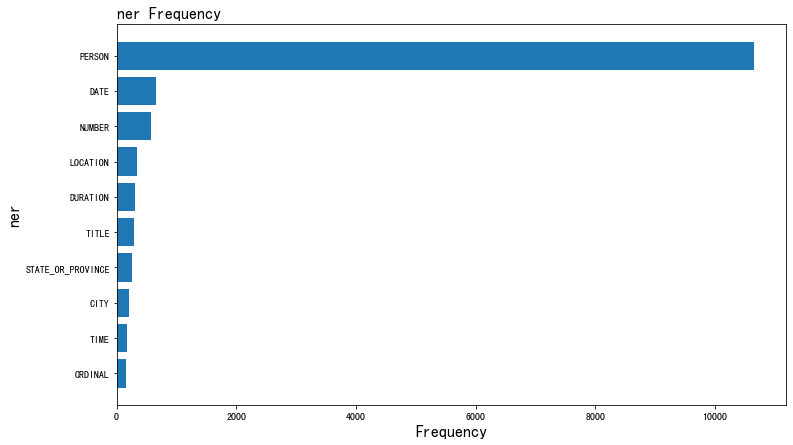

In [18]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 16)
ax.set_ylabel('ner', size = 16)
ax.set_xlabel('Frequency', size = 16)
fig.show()

為了正確計算詞頻，將字詞轉小寫存新欄位

In [19]:
mention['word_lower'] = mention['mention'].str.lower()
mention.tail()

,chapter,mention,ner,word_lower
13852,61,Gardiners,LOCATION,gardiners
13853,61,Darcy,PERSON,darcy
13854,61,Elizabeth,PERSON,elizabeth
13855,61,Derbyshire,STATE_OR_PROVINCE,derbyshire
13856,61,her,PERSON,her


### 涉及到的地點(LOCATION)
+ 透過coreNLP中的NER解析出在傲慢與偏見中所涉及到的地點(LOCATION)

In [20]:
# 篩選ner為country的資料
location = mention.loc[mention['ner'] == 'LOCATION']

# 計算每個地點提到的次數，選出前8個
location_count = location[['word_lower']].groupby(['word_lower'])['word_lower'].count().reset_index(name='count')
location_count = location_count.sort_values(['count'], ascending=False).head(8)
location_count

,word_lower,count
21,longbourn,74
27,netherfield,68
24,meryton,52
32,pemberley,30
34,rosings,20
15,hunsford,16
1,bingley,14
9,fitzwilliam,13


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_78223/328278394.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


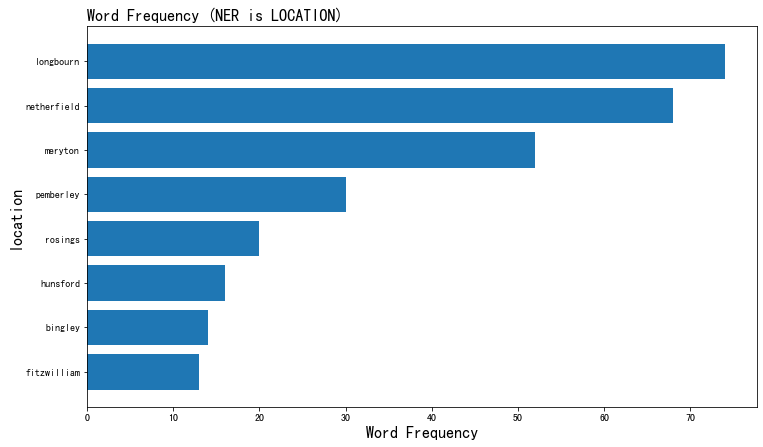

In [21]:
word = location_count['word_lower']
count = location_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is LOCATION)',loc ='left', size = 16)
ax.set_ylabel('location', size = 16)
ax.set_xlabel('Word Frequency', size = 16)
fig.show()

+ 可以抓取關鍵字地點，看看相關的章節大致在說甚麼   

In [22]:
keyword_list = ['hunsford']
ids = location[location['word_lower'].str.contains('|'.join(keyword_list),regex=True, case=False)].chapter
df = df_chapter[df_chapter['chapter'].isin(ids)]
print(f"{' '.join(keyword_list)}：{df.shape[0]}個相關章節")
df

hunsford：13個相關章節


,chapter,sentence
15,15,"Mr. Collins was not a sensible man, and the de..."
19,19,The next day opened a new scene at Longbourn. ...
23,23,Elizabeth was sitting with her mother and sist...
26,26,Mrs. Gardiner's caution to Elizabeth was punct...
27,27,With no greater events than these in the Longb...
28,28,When they left the high road for the lane to H...
30,30,Sir William staid only a week at Hunsford; but...
32,32,Elizabeth was sitting by herself the next morn...
33,33,More than once did Elizabeth in her ramble wit...
37,37,The two gentlemen left Rosings the next mornin...


### 涉及到的城市(CITY)
+ 我們可以透過coreNLP中的NER解析出在傲慢與偏見中所涉及到的城市(CITY)

In [23]:
# 篩選ner為country的資料
city = mention.loc[mention['ner'] == 'CITY']

# 計算每個地點提到的次數，選出前8個
location_city = city[['word_lower']].groupby(['word_lower'])['word_lower'].count().reset_index(name='count')
location_city = location_city.sort_values(['count'], ascending=False).head(8)
location_city

,word_lower,count
3,charlotte,64
9,london,57
7,hertfordshire,41
1,brighton,24
8,kent,6
5,epsom,3
0,birmingham,1
2,cambridge,1


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_78223/271953708.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


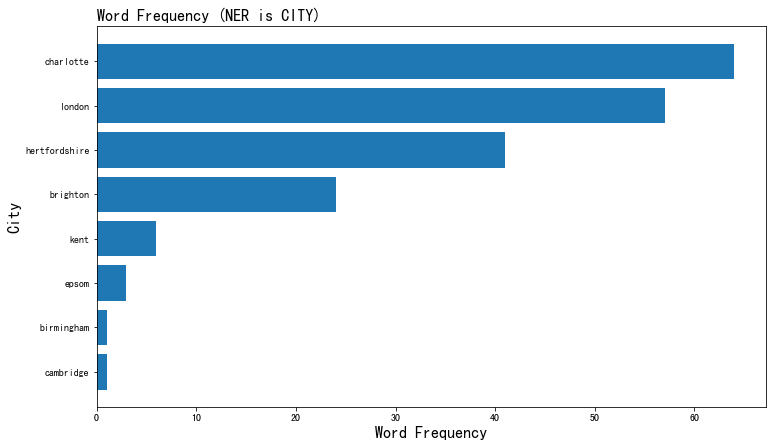

In [24]:
word = location_city['word_lower']
count = location_city['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is CITY)',loc ='left', size = 16)
ax.set_ylabel('City', size = 16)
ax.set_xlabel('Word Frequency', size = 16)
fig.show()

In [25]:
# 查看特定關鍵字的貼文內容
keyword_list = ['brighton']
ids = city[city['word_lower'].str.contains('|'.join(keyword_list),regex=True, case=False)].chapter
df = df_chapter[df_chapter['chapter'].isin(ids)]
print(f"{' '.join(keyword_list)}：{df.shape[0]}個相關章節")
df

brighton：7個相關章節


,chapter,sentence
39,39,"It was the second week in May, in which the th..."
41,41,The first week of their return was soon gone. ...
46,46,Elizabeth had been a good deal disappointed in...
47,47,"It appears to me so very unlikely, that any yo..."
48,48,The whole party were in hopes of a letter from...
50,50,"Mr. Bennet had very often wished, before this ..."
51,51,Their sister's wedding day arrived; and Jane a...


### 涉及到的人物(PERSON)
+ 我們可以透過coreNLP中的NER解析出在傲慢與偏見中所涉及到的人物(PERSON)
+ 有些人稱代名詞(personal pronoun) 像 her或 his， 在 `mention` 裡屬於 `PERSON` ，但應該更接近於 `token` 裡面的 `O`分類，在計算詞頻的時候把他們先過濾掉

In [26]:
# 查看 her 的 NER 分類 
keyword_list = ['her']
print("for ner:", tokens.loc[tokens['word'] == 'her'].ner.unique()) 
print("for entityMention:", mention.loc[mention['word_lower'] == 'her'].ner.unique()) 

for ner: ['O']
for entityMention: ['PERSON']


In [27]:
peo = mention.loc[mention['ner'] == 'PERSON']

# 手動移除coreNLP分不好的字詞
remove_l = ['her','his','he','she','him']
peo = peo[~peo.word_lower.isin(remove_l)]

peo_count = peo[['word_lower']].groupby(['word_lower'])['word_lower'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
peo_count.head()

,word_lower,count
29,elizabeth,611
21,darcy,412
5,bennet,301
51,jane,287
6,bingley,224


/var/folders/wb/4p2wtwfn0hbfl5wk9721_6gm0000gn/T/ipykernel_78223/3454232053.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


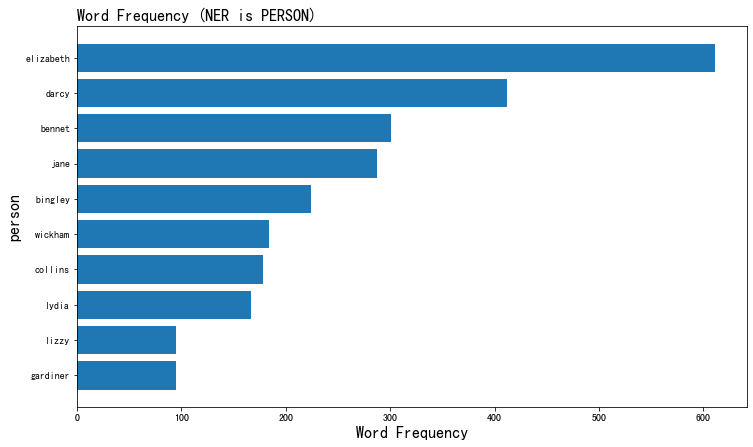

In [28]:
word = peo_count['word_lower']
count = peo_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 16)
ax.set_ylabel('person', size = 16)
ax.set_xlabel('Word Frequency', size = 16)
fig.show()

+ Elizabeth: Elizabeth Bennet，傲慢與偏見女主角。
+ Darcy: Fitzwilliam Darcy，傲慢與偏見男主角，一位富有的紳士，英格蘭德比郡的大地主。
+ Collins: William Collins，自以為是、嘮叨而勢利的牧師。

In [29]:
# 查看特定關鍵字的貼文內容
keyword_list = ['collins']
ids = peo[peo['word_lower'].str.contains('|'.join(keyword_list),regex=True, case=False)].chapter
df = df_chapter[df_chapter['chapter'].isin(ids)]
print(f"{' '.join(keyword_list)}：{df.shape[0]}個相關章節")
df.head()

collins：30個相關章節


,chapter,sentence
13,13,"""I hope, my dear,"" said Mr. Bennet to his wife..."
14,14,"During dinner, Mr. Bennet scarcely spoke at al..."
15,15,"Mr. Collins was not a sensible man, and the de..."
16,16,As no objection was made to the young people's...
17,17,"Elizabeth related to Jane the next day, what h..."


### 3.3 探索分析 - Sentiment
將經過coreNLP處理後的文集，進行情緒分析

In [30]:
# 讀取已經執行完畢的結果
sentiment = pd.read_csv("raw_data/eng/sentiment_tp.csv")
sentiment.head(5)

,chapter,sentence,sentiment
0,0,TPRIDE & PREJUDICE .,Neutral
1,1,"It is a truth universally acknowledged , that...",Positive
2,1,However little known the feelings or views of...,Negative
3,1,""" My dear Mr. Bennet , "" said his lady to him...",Neutral
4,1,Mr. Bennet replied that he had not .,Negative


In [31]:
# 看有哪些情緒
sentiment['sentiment'].unique()

array(['Neutral', 'Positive', 'Negative', 'Very positive',
       'Very negative'], dtype=object)

In [32]:
# 看一下各情緒的分布
sentiment.groupby('sentiment')['sentiment'].agg(['count'])

,count
sentiment,
Negative,2661
Neutral,2046
Positive,1318
Very negative,2
Very positive,20


In [33]:
# 將情緒轉為分數
def label_sentiment(row):
    if row['sentiment'] == "Very positive" :
        return 2
    if row['sentiment'] == "Positive" :
        return 1
    if row['sentiment'] == "Neutral" :
        return 0
    if row['sentiment'] == "Negative" :
        return -1
    if row['sentiment'] == "Very negative" :
        return -2

In [34]:
sentiment['sentimentValue'] = sentiment.apply(lambda row: label_sentiment(row), axis=1)
sentiment.head()

,chapter,sentence,sentiment,sentimentValue
0,0,TPRIDE & PREJUDICE .,Neutral,0
1,1,"It is a truth universally acknowledged , that...",Positive,1
2,1,However little known the feelings or views of...,Negative,-1
3,1,""" My dear Mr. Bennet , "" said his lady to him...",Neutral,0
4,1,Mr. Bennet replied that he had not .,Negative,-1


+ 平均情緒分數章節趨勢

In [35]:
# 算出各章節平均情緒分數
sentiment_count = sentiment.groupby(['chapter'])['sentimentValue'].mean().reset_index()
sentiment_count

,chapter,sentimentValue
0,0,0.000000
1,1,-0.163934
2,2,-0.433962
3,3,-0.079545
4,4,-0.054545
...,...,...
57,57,-0.278481
58,58,-0.313869
59,59,-0.038889
60,60,-0.116279


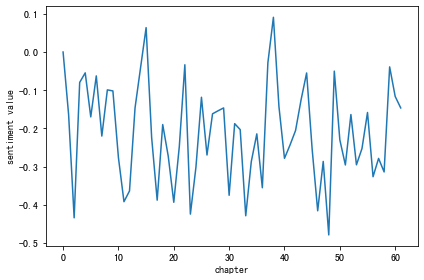

In [36]:
# 平均情緒分數時間趨勢
plt.plot(sentiment_count['chapter'].values, sentiment_count['sentimentValue'].values , linestyle='solid')
plt.xlabel('chapter') # x軸標題
plt.ylabel('sentiment value') # y軸標題
plt.tight_layout()
plt.show()

### 正面詞彙探索
把正面章節挑出來，看看他們都用甚麼詞

In [37]:
# 把 token 的字詞降大小寫
tokens['lemma_lower'] = tokens['lemma'].str.lower()

In [38]:
# 挑出正面詞彙
positive = sentiment[sentiment['sentiment'].isin(['Very positive'])]
positive_words = pd.merge(positive,tokens,on='chapter',how='left')
positive_words.head()

,chapter,sentence,sentiment,sentimentValue,word,lemma,pos,ner,lemma_lower
0,3,she is the most beautiful creature I ever beh...,Very positive,2,Not,not,RB,O,not
1,3,she is the most beautiful creature I ever beh...,Very positive,2,all,all,DT,O,all
2,3,she is the most beautiful creature I ever beh...,Very positive,2,that,that,WDT,O,that
3,3,she is the most beautiful creature I ever beh...,Very positive,2,Mrs.,Mrs.,NNP,O,mrs.
4,3,she is the most beautiful creature I ever beh...,Very positive,2,Bennet,Bennet,NNP,PERSON,bennet


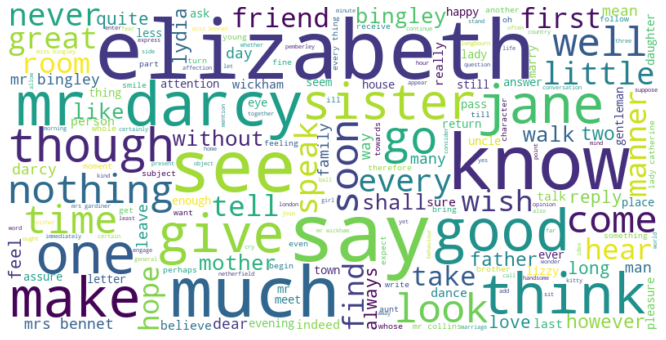

In [39]:
# 匯入預設的stop words，也可以自訂
stop_words = set(stopwords.words('english'))
stop_words.update(["could", "would", "might", "may", "_", "must"])

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words,
                max_font_size=100, width=800, height = 400, background_color="white")\
                .generate(' '.join(positive_words['lemma_lower']))

# Display the generated image:
plt.figure(figsize = (12,6))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

In [40]:
# 挑出負面詞彙
negative = sentiment[sentiment['sentiment'].isin(['Very negative'])]
negative_words = pd.merge(negative,tokens,on='chapter',how='left')
negative_words.head()

,chapter,sentence,sentiment,sentimentValue,word,lemma,pos,ner,lemma_lower
0,3,Mr. Darcy walked off ; and Elizabeth remained...,Very negative,-2,Not,not,RB,O,not
1,3,Mr. Darcy walked off ; and Elizabeth remained...,Very negative,-2,all,all,DT,O,all
2,3,Mr. Darcy walked off ; and Elizabeth remained...,Very negative,-2,that,that,WDT,O,that
3,3,Mr. Darcy walked off ; and Elizabeth remained...,Very negative,-2,Mrs.,Mrs.,NNP,O,mrs.
4,3,Mr. Darcy walked off ; and Elizabeth remained...,Very negative,-2,Bennet,Bennet,NNP,PERSON,bennet


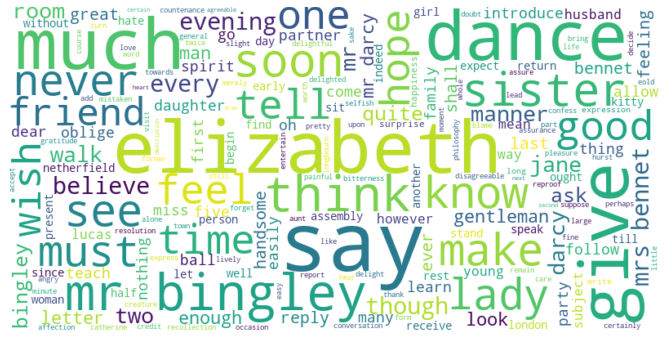

In [41]:
# 匯入預設的stop words 也可以自訂
stop_words = set(stopwords.words('english'))
stop_words.update(["could", "would", "might", "may", "_"])

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words,
                max_font_size=100, width=800, height = 400, background_color="white")\
                .generate(' '.join(negative_words['lemma_lower']))

# Display the generated image:
plt.figure(figsize = (12,6))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

正負面文字雲相比之下，會發現特定人名如mr darcy多數出現在正面場景，而mr bingley在極度負面的場景中出現的比率非常高。<br><br>
同學們可以結合前兩週的方法，從文集中探索出更多insights

## 4. TextBlob

+ 除了coreNLP 還有一些比較簡單的套件可以處理文字，在這裡介紹textBlob，https://github.com/sloria/TextBlob
+ 根據analyzer不同，可分為 lexicon-based 和 corpus-based 情緒分析
+ 情緒計算
    + lexicon-based
        + polarity > 0 是正面的字，反之是負面的
        + subjectivity 代表有多主觀
    + corpus-based
        + classification 代表分類後的情緒為正面(pos)還是負面(neg)
        + p_pos 代表positive的機率
        + p_neg 代表negative的機率
+ 我們把正負面的貼文挑出來，然後再看看通常正負面的貼文都用什麼樣的字

In [42]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
# Corpus-based 的 TextBlob
# 獲得一個句子的情緒分類以及正負面情緒
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!", analyzer = NaiveBayesAnalyzer())
testimonial.sentiment

Sentiment(classification='pos', p_pos=0.861651708233218, p_neg=0.13834829176678198)

In [43]:
# Lexicon-based 的 TextBlob
# 獲得一個句子的正負面情緒以及主觀程度
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
testimonial.sentiment

Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)

因為是lexicon-based，所以可以觀察 TextBlob 對於強調詞和否定詞的效果

In [44]:
testimonial = TextBlob("She looks gorgeous.")
testimonial.sentiment

Sentiment(polarity=0.7, subjectivity=0.9)

In [45]:
# 新增強調詞: very
testimonial = TextBlob("She looks very gorgeous")
testimonial.sentiment

Sentiment(polarity=0.9099999999999999, subjectivity=1.0)

In [46]:
# 新增否定詞: not
testimonial = TextBlob("She looks not very gorgeous")
testimonial.sentiment

Sentiment(polarity=-0.26923076923076916, subjectivity=0.6923076923076923)

In [47]:
# 也可以看到一樣的句子在 corpus-based 中並不會被判斷為負面
testimonial = TextBlob("She looks not very gorgeous", analyzer = NaiveBayesAnalyzer())
testimonial.sentiment

Sentiment(classification='pos', p_pos=0.5411926381089733, p_neg=0.45880736189102644)

將傲慢與偏見套入 TextBlob，計算情緒

In [48]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

df_chapter['polarity'] = df_chapter['sentence'].apply(sentiment_calc)
df_chapter

,chapter,sentence,polarity
0,0,﻿TPRIDE & PREJUDICE.,0.000000
1,1,"It is a truth universally acknowledged, that a...",0.113349
2,2,Mr. Bennet was among the earliest of those who...,0.085062
3,3,"Not all that Mrs. Bennet, however, with the as...",0.179997
4,4,"When Jane and Elizabeth were alone, the former...",0.299587
...,...,...,...
57,57,"The discomposure of spirits, which this extrao...",0.143677
58,58,Instead of receiving any such letter of excuse...,0.064096
59,59,"""My dear Lizzy, where can you have been walkin...",0.194092
60,60,Elizabeth's spirits soon rising to playfulness...,0.129241


In [49]:
# 挑出正負面情緒
positive = df_chapter.loc[df_chapter['polarity'] > 0][['chapter','polarity']]
negative = df_chapter.loc[df_chapter['polarity'] < 0][['chapter','polarity']]

In [50]:
positive.head()

,chapter,polarity
1,1,0.113349
2,2,0.085062
3,3,0.179997
4,4,0.299587
5,5,0.206245


In [51]:
# 去除停用字和標點符號
stop_words = set(stopwords.words('english'))
stop_words.update(["could", "would","might","may","_","must"])
filter_tokens = tokens[~tokens.word.isin(list(stop_words))] 
filter_tokens = filter_tokens[filter_tokens.lemma_lower.str.isalpha()] 

In [52]:
filter_tokens.head(5)

,chapter,word,lemma,pos,ner,lemma_lower
0,0,TPRIDE,TPRIDE,NNP,O,tpride
2,0,PREJUDICE,PREJUDICE,NNP,O,prejudice
4,1,It,it,PRP,O,it
7,1,truth,truth,NN,O,truth
8,1,universally,universally,RB,O,universally


In [53]:
positive_words = pd.merge(positive,filter_tokens[['chapter','lemma_lower']],on='chapter',how='left')

看一下正面的句子都用甚麼樣的詞

In [54]:
positive_words.groupby(['lemma_lower'])['lemma_lower'] \
                         .count() \
                         .reset_index(name='count') \
                         .sort_values(['count'], ascending=False) \
                         .head(10)

,lemma_lower,count
2022,i,2067
1355,elizabeth,630
3519,say,610
983,darcy,418
3622,she,412
3563,see,389
2345,know,388
2494,make,335
4026,think,330
2650,much,327


### 補充：其他英文處理套件

#### emoji
+  emoji 轉英文字

In [103]:
# %pip install emoji

In [83]:
# emoji to text
import emoji 
print(emoji.demojize('Python is 👍'))

Python is :thumbs_up:


#### vaderSentiment
+ 分析英文句子情緒

In [105]:
# %pip install vaderSentiment

In [84]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
At least it isn't a horrible book.------------------------------- {'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.431}
The book was only kind of good.---------------------------------- {'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'compound': 0.3832}
The plot was good, but the characters are uncompelling and the dialog is not great. {'neg': 0.327, 'neu': 0.579, 'pos': 0.094, 'compound': -0.7042}
Today SUX!------------------------------------------------------- {'neg': 0.779, 'neu': 0.221, 'pos': 0.0, 'compound': -0.5461}
Today only kinda sux! But I'll get by, lol----------------------- {'neg': 0.127, 'neu': 0.556, 'pos': 0.317, 'compound': 0.5249}
Make sure you :) or :D today!------------------------------------ {'neg': 0.0, 'neu': 0.

#### sentimentpy
+ github: https://github.com/trinker/sentimentpy
+ 請用這種方式安裝 `pip install git+https://github.com/trinker/sentimentpy`

In [107]:
# %pip install git+https://github.com/trinker/sentimentpy

In [292]:
# 把句子斷開，去除結尾空白符號
import sentimentpy.split_sentences as ss

s = [
    'I like carrots too mrs. dunbar. Well let\'s go to 100th st. around the corner.   ',
    'Hello Dr. Livingstone.  How are you?',
    'This is sill an incomplete thou.'
]

ss.split_sentences(s)

['I like carrots too mrs. dunbar.',
 "Well let's go to 100th st. around the corner.",
 'Hello Dr. Livingstone.',
 'How are you?',
 'This is sill an incomplete thou.']